## Descriptives Notebook

In [1]:
# Data Manipulation
# ======================================================
import pandas as pd 
import numpy as np
from epiweeks import Week
from datetime import datetime
from calendar import month_name, month_abbr
from os import path
import configparser

# Reading Secrets
# ======================================================
cfg = configparser.ConfigParser()
cfg.read('secrets.ini')
ROOT_PATH = path.abspath(cfg.get('default','root'))
DATA_PATH = path.join(ROOT_PATH, 'datasets/data')

# Warnings Config
# ======================================================
import warnings
warnings.filterwarnings('ignore')

# Statistics
# ======================================================
import statsmodels.api as sm
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler

# Plotting
# ======================================================
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
# Loading & manipulating dataset
# ======================================================

col_ordered = (
                'cases','visits','GS_cold', 
                'GS_cough', 'GS_fever', 'GS_flu', 
                'AWND', 'PRCP', 'SNOW', 
                'TMAX', 'TMIN', 'TAVG',
                'Overall AQI Value',
                'CO', 'Ozone', 'PM10', 
                'PM25', 'Days Good',
                'Days Moderate', 'Days Unhealthy'
                )

df = pd.read_csv(path.join(DATA_PATH, 'raw_dataset.csv'))

df['epiweek'] = df['epiweek'].map(lambda x: Week.fromstring(str(x)))
df['weekstart'] = pd.to_datetime(df['epiweek'].map(lambda x: Week.startdate(x)))
df.set_index('weekstart', inplace=True)
df['epiweek'] = df['epiweek'].map(lambda x: int(str(x)[4:]))
means = df[list(col_ordered)].groupby(df.index.month).mean()
means.index.name = 'month'
df['month'] = df.index.month
df = df.reset_index().set_index(['weekstart','month'])
df['TAVG'] = df[['TAVG']].fillna(pd.DataFrame((df['TMAX'] + df['TMIN']) / 2)\
                                .rename(columns={0:'TAVG'}))
df[list(col_ordered)] = df[list(col_ordered)].fillna(means)
df['Main Pollutant'] = df['Main Pollutant'].astype('category')
df = pd.get_dummies(df).drop(columns=["Main Pollutant_['Ozone' 'PM2.5']"])

In [3]:
# Means by month 
# ======================================================

m = means.T
m = m.T.rename(columns={
                        'visits':'EDvisits',
                        'GS_cold':"'cold'",
                        'GS_cough':"'cough'",
                        'GS_fever':"'fever'",
                        'GS_flu':"'flu'",
                        'AWND':'wind',
                        'PRCP':'precip',
                        'SNOW':'snow',
                        'TAVG':'avg temp',
                        'TMAX':'max temp',
                        'TMIN':'min temp',
                        'Overall AQI Value':'AQI',
                        'PM25':'PM2.5'
                        }
                ).T

m[' '] = ('Surveillance','Surveillance',
        'Google Trends','Google Trends',
        'Google Trends','Google Trends',
        'Weather','Weather','Weather',
        'Weather','Weather','Weather',
        'Air Quality','Air Quality',
        'Air Quality','Air Quality',
        'Air Quality','Air Quality',
        'Air Quality','Air Quality')

m = m.reset_index()\
    .rename(columns={'index':''})\
    .set_index([' ','']).T

m \
    .style \
    .format(precision=1) \
    .set_properties(**{'text-align':'center'}) \
    .relabel_index([month_abbr[i] for i in range(1,13)]) \
    .set_table_styles([
        dict(selector='caption', props=[('font-size','26px'),('font-weight','300')]), 
        dict(selector='th', props=[('text-align','left'),('font-weight','500')]) ,
        dict(selector='', props=[('border','1px solid grey')])]) \
    .set_caption('Table 1: Variable Means by Month', ) 


In [4]:
# Scaling & standardizing
# ======================================================

df_std = df\
        .rename(
                columns={
                        'visits':'EDvisits',
                        'AWND':'wind',
                        'PRCP':'precip',
                        'SNOW':'snow',
                        'TAVG':'avg temp',
                        'TMAX':'max temp',
                        'TMIN':'min temp',
                        'Overall AQI Value':'AQI',
                        'PM25':'PM2.5'
                        }
                )\
        .drop(
                columns=[
                        'epiweek',
                        'Days Good',
                        'cases',
                        'Main Pollutant_CO',
                        'Main Pollutant_NO2',
                        'Main Pollutant_Ozone',
                        'Main Pollutant_PM2.5'
                        ]
                )

df_std[df_std.columns] = StandardScaler()\
                        .fit_transform(df_std)

df_mstd = df_std\
        .reset_index()\
        .set_index('weekstart')\
        .drop(columns=['month'])

df_mstd = df_mstd\
        .groupby(df_mstd.index.month)\
        .mean()

df_mstd.index.names = ['Month']
df_mstd.reset_index(inplace=True)

df_mstd['Month'] = df_mstd['Month']\
                .apply(lambda x: month_abbr[x])

df_mstd.set_index('Month',inplace=True)
df_mstd = df_mstd.melt(ignore_index=False)

df_std = df_std.reset_index().drop(columns=['month']).set_index('weekstart')

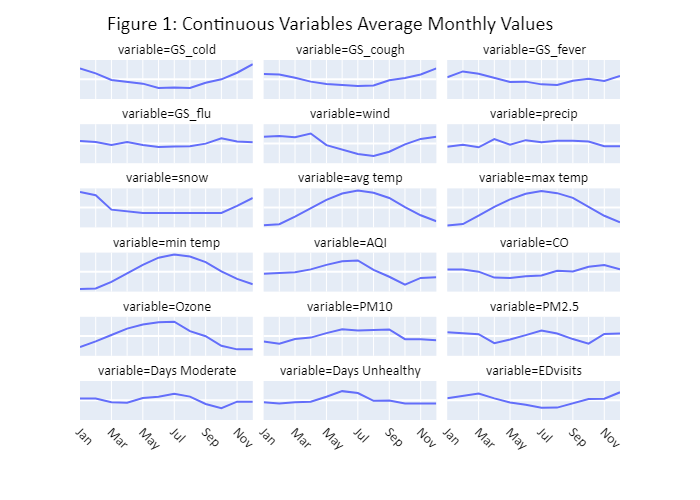

In [5]:
# Monthly average values line plot 
# ======================================================

fig = px.line(
            data_frame = df_mstd.reset_index(), 
            x = 'Month', 
            y = 'value', 
            facet_col = 'variable', 
            facet_col_wrap = 3
            )

fig.update_layout(
                font_color='black',
                font_family='Calibri',
                font_size=14,
                title='Figure 1: Continuous Variables Average Monthly Values',
                title_xref = 'paper',
                title_xanchor = 'auto',
                )

fig.update_xaxes(title='',tickangle=45)
fig.update_yaxes(title='',tickvals=['','',''])

fig.show('png')

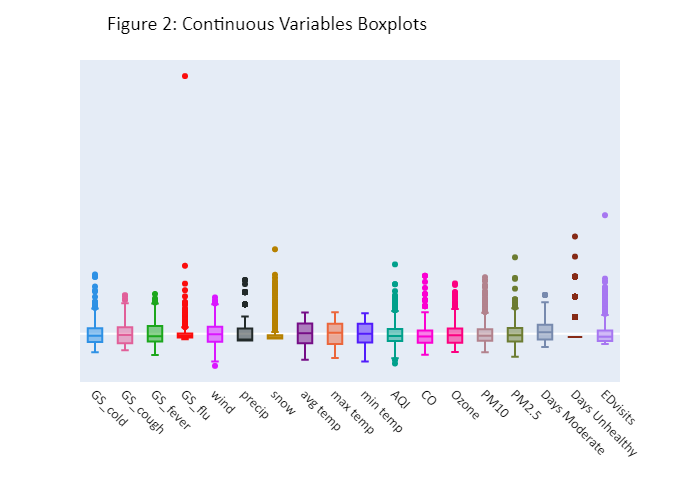

In [6]:
# Boxplots 
# ======================================================

fig = px.box(
            data_frame = df_std.melt(ignore_index=False),
            y = 'value',
            x = 'variable', 
            color = 'variable',
            color_discrete_sequence = px.colors.qualitative.Dark24
            )

fig.update_layout(
                title='Figure 2: Continuous Variables Boxplots',
                font_color='black',
                font_family='Calibri',
                font_size=14,
                showlegend = False,
                title_xref = 'paper',
                title_xanchor = 'auto',
                )

fig.update_yaxes(title='',tickvals=['','','','','',''])
fig.update_xaxes(title='',tickangle=45)

fig.show('png')

In [7]:
# Correlation matrix 
# ======================================================

corr_matrix = df_std.corr()
pvals = df_std.corr(method=lambda x,y: pearsonr(x,y)[1]) - np.eye(*corr_matrix.shape)

p = pvals\
    .applymap(
        lambda x: 
        ''.join(['*' for t in [0.05,0.01,0.001] if x<=t]))

corr_matrix_sigs = corr_matrix.round(2).astype(str) + p
corr_matrix_sigs

,GS_cold,GS_cough,GS_fever,GS_flu,wind,precip,snow,avg temp,max temp,min temp,AQI,CO,Ozone,PM10,PM2.5,Days Moderate,Days Unhealthy,EDvisits
GS_cold,1.0***,0.83***,0.7***,0.14***,0.31***,-0.04,0.38***,-0.56***,-0.57***,-0.54***,-0.33***,0.04,-0.43***,-0.27***,-0.25***,-0.2***,-0.21***,0.46***
GS_cough,0.83***,1.0***,0.85***,0.09**,0.25***,-0.0,0.16***,-0.36***,-0.37***,-0.35***,-0.35***,-0.01,-0.37***,-0.23***,-0.34***,-0.25***,-0.24***,0.57***
GS_fever,0.7***,0.85***,1.0***,0.16***,0.2***,0.05,0.07*,-0.24***,-0.24***,-0.23***,-0.25***,0.02,-0.2***,-0.14***,-0.32***,-0.22***,-0.18***,0.54***
GS_flu,0.14***,0.09**,0.16***,1.0***,0.09*,0.05,0.04,-0.12***,-0.13***,-0.12***,-0.18***,0.02,-0.18***,-0.11**,-0.12***,-0.12***,-0.08*,0.22***
wind,0.31***,0.25***,0.2***,0.09*,1.0***,0.13***,0.31***,-0.5***,-0.51***,-0.48***,-0.3***,-0.2***,-0.3***,-0.33***,-0.27***,-0.27***,-0.19***,0.19***
precip,-0.04,-0.0,0.05,0.05,0.13***,1.0***,-0.01,0.17***,0.15***,0.2***,-0.11**,-0.05,-0.03,-0.07*,-0.16***,-0.1**,-0.07,-0.01
snow,0.38***,0.16***,0.07*,0.04,0.31***,-0.01,1.0***,-0.58***,-0.58***,-0.56***,-0.14***,-0.02,-0.29***,-0.27***,0.02,-0.01,-0.11***,0.08*
avg temp,-0.56***,-0.36***,-0.24***,-0.12***,-0.5***,0.17***,-0.58***,1.0***,1.0***,0.99***,0.36***,-0.11***,0.63***,0.41***,0.03,0.17***,0.27***,-0.32***
max temp,-0.57***,-0.37***,-0.24***,-0.13***,-0.51***,0.15***,-0.58***,1.0***,1.0***,0.98***,0.38***,-0.1**,0.66***,0.43***,0.04,0.18***,0.28***,-0.32***
min temp,-0.54***,-0.35***,-0.23***,-0.12***,-0.48***,0.2***,-0.56***,0.99***,0.98***,1.0***,0.33***,-0.12***,0.59***,0.39***,0.02,0.15***,0.26***,-0.31***


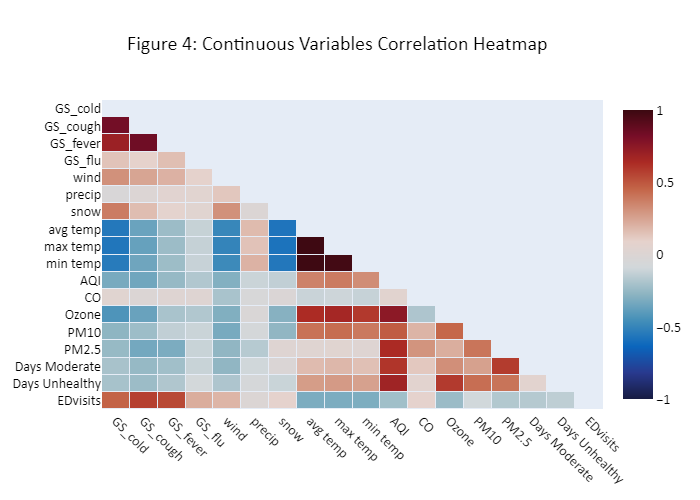

In [8]:
# Correlation matrix heatmap 
# ======================================================

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
rLT = corr_matrix.mask(mask)

heat = go.Heatmap(
                    z = rLT,
                    x = rLT.columns.values,
                    y = rLT.columns.values,
                    zmin = - 1, # Sets the lower bound of the color domain
                    zmax = 1,
                    xgap = 1, # Sets the horizontal gap (in pixels) between bricks
                    ygap = 1,
                    colorscale = 'balance'
                )

title='Figure 4: Continuous Variables Correlation Heatmap'

layout = go.Layout(
                    title_text=title, 
                    # title_x=0.5, 
                    # width=600, 
                    # height=600,
                    xaxis_showgrid=False,
                    yaxis_showgrid=False,
                    yaxis_autorange='reversed', 
                    font_color='black',
                    font_family='Calibri',
                    font_size=14,
                    title_xref = 'paper',
                    title_xanchor = 'auto'
                )

fig=go.Figure(data=[heat], layout=layout)
fig.update_yaxes(tickvals=[c for c in corr_matrix.columns])
fig.update_xaxes(tickangle=45)
fig.show('png')

In [9]:
# Monthly main pollutant dataset 
# ======================================================

df_poll = df[['Main Pollutant_CO','Main Pollutant_NO2',
            'Main Pollutant_Ozone','Main Pollutant_PM2.5']]\
            .reset_index().set_index('weekstart')

df_poll['month'] = df_poll['month'].map(lambda x: month_abbr[x])
df_poll = df_poll.groupby('month').sum()
df_poll = df_poll\
            .rename(
                columns={
                        'Main Pollutant_CO':'CO',
                        'Main Pollutant_NO2':'NO2',
                        'Main Pollutant_Ozone':'Ozone',
                        'Main Pollutant_PM2.5':'PM2.5'
                        })\
            .T.melt(
                ignore_index=False, 
                value_vars=[month_abbr[i] for i in range(1,13)]
                    )

df_poll = df_poll.reset_index()\
        .rename(columns={
                        'index':'Main Pollutant',
                        'month':'Month',
                        'value':'freq'
                        })

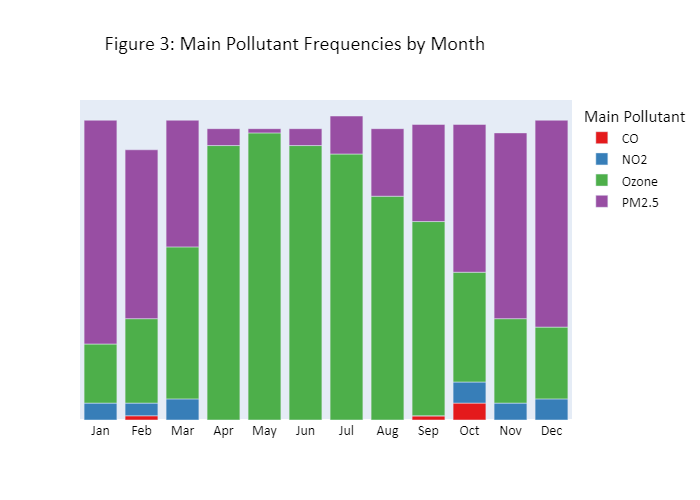

In [10]:
# Main pollutant by month stacked boxplot
# ======================================================

fig = px.bar(df_poll, x='Month',y='freq',color='Main Pollutant',
            title='Figure 3: Main Pollutant Frequencies by Month',
            color_discrete_sequence = px.colors.qualitative.Set1
            )

fig.update_layout(font_color='black'
                ,font_family='Calibri'
                , font_size=14
                , title_xref = 'paper',
                title_xanchor = 'auto')

fig.update_xaxes(title='')
fig.update_yaxes(title='',tickvals=['','','','','','','',''])
fig.show('png')

In [12]:
cases = df.reset_index().set_index('weekstart')['cases']

In [15]:
cases = cases.astype('float')

In [78]:
from statsmodels.tsa.stattools import acf
import plotly.graph_objects as go

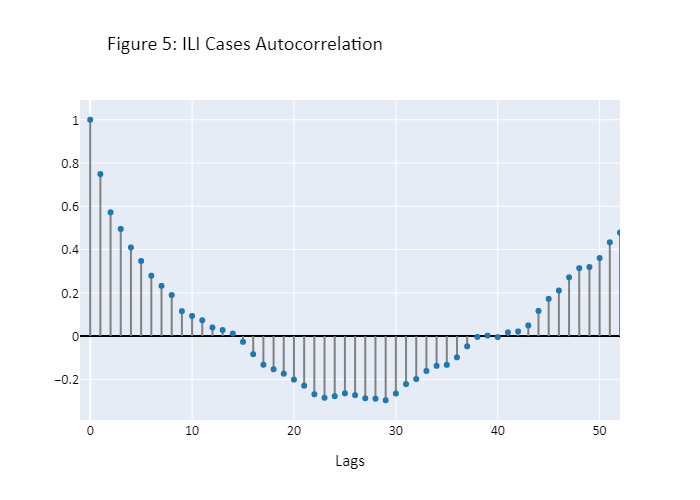

In [105]:
corr_array = acf(cases, alpha=0.05, nlags=52)
lower_y = corr_array[1][:,0] - corr_array[0]
upper_y = corr_array[1][:,1] - corr_array[0]

fig = go.Figure()
[fig.add_scatter(x=(x,x), y=(0,corr_array[0][x]), mode='lines',line_color='grey') 
for x in range(len(corr_array[0]))]
fig.add_scatter(x=np.arange(len(corr_array[0])), y=corr_array[0], mode='markers', marker_color='#1f77b4',
                marker_size=6)

fig.update_xaxes(range=[-1,52], title='Lags')
fig.update_yaxes(zerolinecolor='#000000')

fig.update_layout(
                title='Figure 5: ILI Cases Autocorrelation',
                font_color='black',
                font_family='Calibri',
                font_size=14,
                showlegend = False,
                title_xref = 'paper',
                title_xanchor = 'auto',
                )
fig.show('png')

